In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

import jax 
import jax.numpy as jnp 

from skimage.filters import window 
jax.config.update("jax_platform_name", "cpu")

import sys
import os
sys.path.insert(0, os.path.abspath(".."))

from kltpicker_3d.tests.power_spectrum import benchmark_exp_autocorrelation

## Walkthrough P.S calculation

In [9]:
def jitted_binarysearch(X,query):
    idx = jnp.searchsorted(X,query,side='left')
    return idx

def calculate_autocorrelation(patch):
    patch_fft = jnp.fft.fftn(patch)
    acf = jnp.fft.ifftn(patch_fft * jnp.conj(patch_fft))
    return acf 

def accumulate_acf_radially(acf,dist_map,valid_dists,dists_counts,init):
    def scan_fn(carry, idx):
        i,j,k = idx
        d = dist_map[i,j,k]
        carry = carry.at[0,d].add(acf[i,j,k])
        carry = carry.at[1,d].add(dists_counts[i,j,k])
        return (carry,None) 

    vv = jnp.stack(valid_dists,axis=-1)
    v, _ = jax.lax.scan(scan_fn,init,vv)
    return v[0,...],v[1,...]


In [10]:
N = 32
M = 2*N - 1 
max_d = int(np.floor(N/3))
T = -np.log(1e-15)/30
grid = np.arange(-(N-1),N)
i,j,k = np.meshgrid(grid,grid,grid)
acf = np.exp(-T * np.sqrt(i**2 + j**2 + k**2))

def cfftn(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x)))

H = cfftn(acf).real
C = M**3 / H.sum()
normalized_H = jnp.fft.ifftshift(jnp.sqrt(H * C)) # The power spectrum we want 

K = 100
samples = np.zeros((K,N,N,N))
for i in range(K):
    gaussian_noise = np.random.normal(size=(M,M,M))
    noise = jnp.fft.ifftn(jnp.fft.fftn(gaussian_noise) * normalized_H)
    samples[i] = noise[:N,:N,:N].real

In [11]:
grid = jnp.arange(max_d+1)
i,j,k = jnp.meshgrid(grid,grid,grid)
d = i**2 + j**2 + k**2
valid_dists = jnp.where(d <= max_d ** 2)
dists = jnp.sort(jnp.unique(d[d <= max_d ** 2]))
   
idx = jitted_binarysearch(dists,d)
dist_map = jnp.zeros(d.shape, dtype=jnp.int32)
dist_map = dist_map.at[valid_dists].set(idx[valid_dists])

corrs = jnp.zeros_like(dists)
corrcount = jnp.zeros_like(dists)


mask = jnp.ones((N,N,N)) 
tmp = jnp.zeros((2*N-1,2*N-1,2*N-1))
tmp = tmp.at[:N,:N,:N].set(mask) 
c_padded = calculate_autocorrelation(tmp)
c = c_padded[:max_d+1,:max_d+1,:max_d+1]
c = jnp.round(c.real).astype(jnp.float32)

R = jnp.zeros_like(corrs)

for k in range(K):
    sample = samples[k]

    tomogram_fft = jnp.zeros((2*N+1,2*N+1,2*N+1),dtype=jnp.complex64)
    tomogram_fft = tomogram_fft.at[:N,:N,:N].set(sample)
    tomogram_acf = calculate_autocorrelation(tomogram_fft).real
    tomogram_acf = tomogram_acf[:max_d+1, :max_d+1,:max_d+1]

    init = jnp.zeros((2,dists.shape[0]))
    r,cnt = accumulate_acf_radially(tomogram_acf, dist_map, valid_dists,c,init)
    corrs += r 
    corrcount += cnt 

idx1 = jnp.where(corrcount != 0)[0]
result = corrs.at[idx1].set(corrs[idx1] / corrcount[idx1])

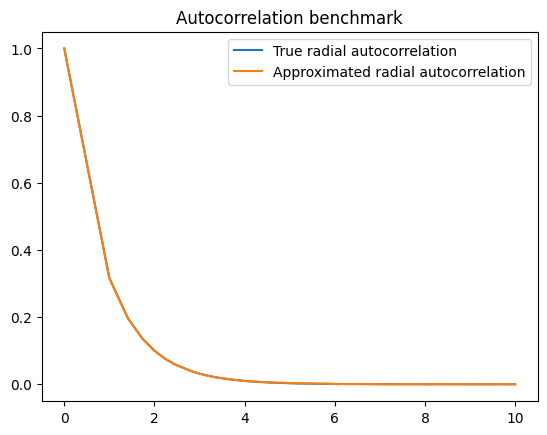

In [12]:
xx = dists ** 0.5
plt.plot(xx, np.exp(-T*xx), label='True radial autocorrelation ')
plt.plot(xx,result, label='Approximated radial autocorrelation')
plt.title("Autocorrelation benchmark")
plt.legend();

In [13]:
r3 = jnp.zeros((2*N-1, 2*N-1,2*N-1))
for i in range(-max_d, max_d):
    for j in range(-max_d, max_d):
        for k in range(-max_d, max_d):
            d = i**2 + j**2 + k**2 
            if d <= max_d ** 2:
                id = jnp.searchsorted(dists,d,side='left')
                r3 = r3.at[(N-1) + i, (N-1) +j, (N-1)+k].set(result[id])

In [14]:
w = jnp.array(window(('gaussian', max_d), (2*N-1,2*N-1,2*N-1)))
p3 = cfftn(r3*w).real  
p3 = jnp.where(p3 < 0, 0, p3) # Truncate negative values 
E = 0
for k in range(K):
    sample = samples[k]
    E += np.sum((sample - jnp.mean(sample)) ** 2)

meanE = E/ (K * N ** 3)
p3 = (p3/ p3.sum()) * meanE *  M ** 3
p3 = p3/jnp.linalg.norm(p3)

In [15]:
w = 2*np.pi/M
grid = np.arange(-(N-1),N)
i,j,k  = np.meshgrid(grid,grid,grid)
omega_x, omega_y, omega_z = w*i, w*j, w*k
poisson_fft = jnp.zeros((M,M,M))
C = 8 * np.pi ** (3/2) / (T**3)
for j1 in range(-10,11):
    for j2 in range(-10,11):
        for j3 in range(-10,11):
            omega_r_squared = (omega_x + j1*2*np.pi)**2 + (omega_y + j2*2*np.pi)**2 + (omega_z + j3*2*np.pi)**2
            poisson_fft += C/(1+ omega_r_squared/(T**2))**2
poisson_fft /= jnp.linalg.norm(poisson_fft)

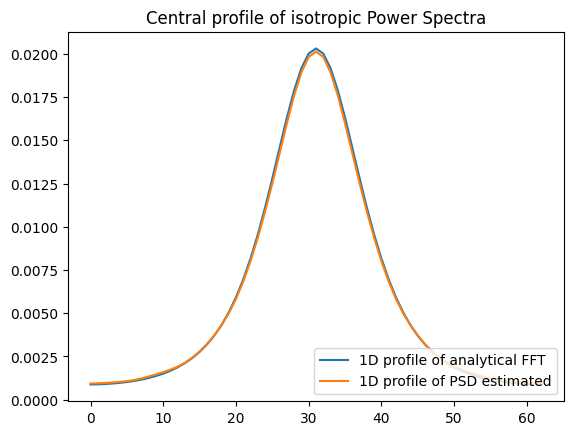

In [16]:
plt.plot(poisson_fft[N,N,:], label='1D profile of analytical FFT');
plt.plot(p3[N,N,:], label='1D profile of PSD estimated')
plt.title("Central profile of isotropic Power Spectra");
plt.legend(loc='lower right');

## Experiments for different values of K

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/power_spectrum.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[i] = cfftn(noise * window)


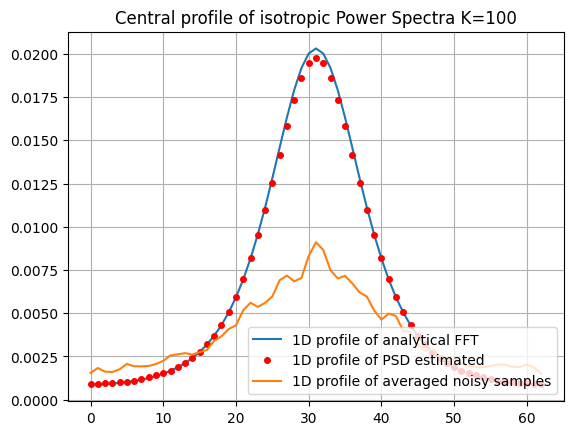

In [3]:
N = 32
p3, spectrum, poisson_fft = benchmark_exp_autocorrelation(N,100)
plt.plot(poisson_fft[N,N,:], label='1D profile of analytical FFT');
plt.plot(p3[N,N,:] ,'ro', markersize=4, label='1D profile of PSD estimated')
plt.plot(spectrum[N,N,:], label='1D profile of averaged noisy samples')
plt.title(f"Central profile of isotropic Power Spectra K={100}")
plt.grid()
plt.legend(loc='lower right');

/scratch/home/moshemaymon/3D_KLT/test_power_spectrum.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[i] = cfftn(noise * window)


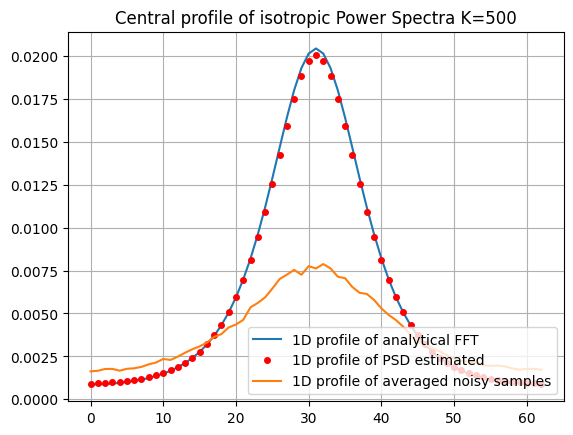

In [18]:
p3, spectrum, poisson_fft = benchmark_exp_autocorrelation(N,500)
plt.plot(poisson_fft[N,N,:], label='1D profile of analytical FFT');
plt.plot(p3[N,N,:] ,'ro', markersize=4, label='1D profile of PSD estimated')
plt.plot(spectrum[N,N,:], label='1D profile of averaged noisy samples')
plt.title(f"Central profile of isotropic Power Spectra K={500}")
plt.grid()
plt.legend(loc='lower right');